# Fig3: eY1H/PDI analyses

- DBD alterations vs PDIs
- vignettes

In [1]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import sys

# import utils
sys.path.append("../")

from data_loading import (load_annotated_TFiso1_collection, 
                          load_y1h_pdi_data, 
                          load_dbd_accessions,
                          load_valid_isoform_clones)
from plotting import y1h_pdi_per_tf_gene_plot, m1h_activation_per_tf_gene_plot

/PHShome/kz659/.conda/envs/tfisos/lib/python3.8/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [2]:
PAPER_PRESET = {"style": "ticks", "font": ["Helvetica", "DejaVu Sans"], "context": "paper", 
                "rc": {"font.size":7,"axes.titlesize":7,
                     "pdf.fonttype": 42, 
                       "axes.labelsize":7, 'axes.linewidth':0.5,
                       "legend.fontsize":6, "xtick.labelsize":6,
                       "ytick.labelsize":6, "xtick.major.size": 3.0,
                       "ytick.major.size": 3.0, "axes.edgecolor": "black",
                       "xtick.major.pad": 3.0, "ytick.major.pad": 3.0}}
PAPER_FONTSIZE = 7

In [3]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [4]:
np.random.seed(2023)

## 1. load PDI data

In [5]:
tfs = load_annotated_TFiso1_collection()

reading from cache


In [6]:
def disordered_fraction_of_different_regions(gene, ref_iso_name, alt_iso_name):
    algn = gene.pairwise_changes_relative_to_reference(ref_iso_name, alt_iso_name)
    if not hasattr(gene[ref_iso_name], 'disorder') or not hasattr(gene[alt_iso_name], 'disorder'):
        return np.nan
    ref_iter = iter(gene[ref_iso_name].disorder)
    alt_iter = iter(gene[alt_iso_name].disorder)
    merged_disorder = []
    for pos in algn:
        if pos == 'I':
            merged_disorder.append(next(alt_iter))
        elif pos == 'D':
            merged_disorder.append(next(ref_iter))
        else:
            merged_disorder.append(next(ref_iter))
            next(alt_iter)

    return np.mean([is_disordered for pos, is_disordered in zip(algn, merged_disorder) if pos != 'M'])


disordered_fraction_of_different_regions(tfs['CREB1'], 'CREB1-2', 'CREB1-1')

1.0

In [7]:
# TODO move to isolib
def n_aa_change_from_feature(gene, ref_iso_name, alt_iso_name, domain_start, domain_end):
    algn = gene.pairwise_changes_relative_to_reference(ref_iso_name, alt_iso_name)

    def _coords_transform_aa_seq_to_alignment(i, alignment):
        if i > len(alignment.replace("I", "")):
            raise ValueError("position is not in isoform AA sequence")
        aa_seq_indices = [
            "" if c == "I" else len(alignment[:j].replace("I", ""))
            for j, c in enumerate(alignment)
        ]
        return aa_seq_indices.index(i)
    
    start = _coords_transform_aa_seq_to_alignment(domain_start, algn)
    end = _coords_transform_aa_seq_to_alignment(domain_end - 1, algn) + 1

    if not all(x == 'M' for x in algn[start:end]):
        return 0  # change is within the domain
    
    big_number = 9999999999999999999999999
    c_dist = big_number
    n_dist = big_number
    for i, l in enumerate(reversed(algn[:start])):
        if l != 'M':
            c_dist = i + 1
            break
    for i, l in enumerate(algn[end:]):
        if l != 'M':
            n_dist = i + 1
            break
    if c_dist == big_number and n_dist == big_number:
        raise UserWarning('problem calculating distance')
    return min([c_dist, n_dist])


def n_aa_to_all_features(self, ref_iso_name):
    results = []
    ref_iso = self[ref_iso_name]
    row = {"gene": self.name, "ref_iso": ref_iso_name}
    for aa_feature in ref_iso.aa_seq_features:
        for alt_iso_name, alt_iso in self._iso_dict.items():
            if alt_iso_name == ref_iso_name:
                continue
            row.update(
                {
                    "alt_iso": alt_iso_name,
                    "accession": aa_feature.accession,
                    "category": aa_feature.category,
                    "start_in_ref_iso": aa_feature.start,
                    "end_in_ref_iso": aa_feature.end,
                    "length": aa_feature.end - aa_feature.start,
                }
            )
            row.update({"n_aa_change_to_domain": n_aa_change_from_feature(self, ref_iso_name, alt_iso_name, aa_feature.start, aa_feature.end)})
            results.append(row.copy())
    results = pd.DataFrame(results)
    return results

In [8]:
dist = pd.concat([n_aa_to_all_features(g, g.cloned_reference_isoform.name) for g in tfs.values()])
dist['is_DBD'] = dist['accession'].isin(load_dbd_accessions())

In [9]:
y1h = load_y1h_pdi_data()

In [10]:
df = pd.concat([g.aa_feature_disruption(g.cloned_reference_isoform.name) for g in tfs.values()])
df['is_DBD'] = df['accession'].isin(load_dbd_accessions())
df['is_DBD_flank'] = (df['accession'].str.endswith('_flank_N') |
                      df['accession'].str.endswith('_flank_C'))
len(df)

7084

In [11]:
df_new = (df.loc[df['is_DBD'], :]
        .groupby(['gene_symbol', 'ref_iso', 'alt_iso'])
        [['deletion', 'frameshift']].sum()
        .sum(axis=1) / df.loc[df['is_DBD'], :]
        .groupby(['gene_symbol', 'ref_iso', 'alt_iso'])
        ['length'].sum()).to_frame(name='dbd_fraction')

df_new['dbd_insertion_n_aa'] = (df.loc[df['is_DBD'], :]
                                  .groupby(['gene_symbol', 'ref_iso', 'alt_iso'])
                                  ['insertion']
                                  .sum())

df_new['dbd_n_aa_to_change'] = (dist.loc[dist['is_DBD'], :]
                                  .groupby(['gene', 'ref_iso', 'alt_iso'])
                                  ['n_aa_change_to_domain']
                                  .min())
len(df_new)

889

In [12]:
# flank affected
df_new['dbd_flank_affected'] = (df.loc[df['is_DBD_flank'], :]
        .groupby(['gene_symbol', 'ref_iso', 'alt_iso'])
        [['deletion', 'insertion', 'frameshift']].sum()
        .sum(axis=1) > 0)
df = df_new.reset_index()
df['dbd_pct_lost'] = df['dbd_fraction'] * 100.
len(df)

889

In [13]:
def dbd_affected_categories(pct_lost):
    if pct_lost < 0:
        raise ValueError('negative percent value')
    elif pct_lost == 0:
        return 'Full DBD in\nalternative isoform'
    elif pct_lost >= 100:
        return 'Full loss\nof DBD'
    else:
        return 'Partial loss\nof DBD'

df['dbd_affected'] = df['dbd_pct_lost'].apply(dbd_affected_categories)
df['dbd_or_flank_affected'] = df['dbd_affected']
df.loc[(df['dbd_affected'] == 'Full DBD in\nalternative isoform') &
       df['dbd_flank_affected'], 'dbd_or_flank_affected'] = 'DBD flank affected'
len(df)

889

In [14]:
isoforms = load_valid_isoform_clones()
len(isoforms)

693

In [15]:
tmp = y1h[y1h['gene_symbol'] == 'TBX5'].drop(columns='gene_symbol').set_index('clone_acc')

# Filter the DataFrame
filtered_df = tmp.loc[["TBX5|1/3|08E01", "TBX5|2/3|08C02"]].dropna(axis=1)  # Remove columns with any <NA>
filtered_df = filtered_df.loc[:, (filtered_df == True).any(axis=0)]  # Keep columns where at least one True is present
filtered_df.loc["TBX5|1/3|08E01"].sum()

8

In [16]:
# map each isoform to change in PDI vs reference
def delta_pdi(row):
    iso_acc = row['alt_iso']
    ref_acc = row['ref_iso']
    if iso_acc == ref_acc:
        return np.nan
    
    # fixed it so now 'missing' baits do not count in pairwise comparisons
    try:
        y1h_tmp = y1h.drop(columns='gene_symbol').set_index('clone_acc')
        y1h_tmp.index = y1h_tmp.index.map(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])
        y1h_filt = y1h_tmp.loc[[ref_acc, iso_acc]].dropna(axis=1)
        y1h_filt = y1h_filt.loc[:, (y1h_filt == True).any(axis=0)]

        n_ref = y1h_filt.loc[ref_acc].sum()
        n_iso = y1h_filt.loc[iso_acc].sum()
    except KeyError:
        n_ref = np.nan
        n_iso = np.nan
    if n_ref == 0:
        return np.nan
    #print("n iso: %s, n ref: %s" % (n_iso, n_ref))
    return (n_iso - n_ref) / n_ref


df['delta_pdi'] = df.apply(delta_pdi, axis=1)
df = df.dropna(subset=['delta_pdi'])

df['tf_family'] = df['gene_symbol'].map(lambda x: tfs[x].tf_family)
df['delta_pdi_trunc'] = df['delta_pdi'].clip(upper=1)

if (((df['dbd_fraction'] > 0) | (df['dbd_insertion_n_aa'] > 0)) & (df['dbd_n_aa_to_change'] > 0)).any():
    raise UserWarning('something wrong with calculations')
if ((df['dbd_fraction'] == 0) & (df['dbd_insertion_n_aa'] == 0) & (df['dbd_n_aa_to_change'] == 0)).any():
    raise UserWarning('something wrong with calculations')
len(df)

61

In [17]:
delta_pdi(df[df['alt_iso'] == 'TBX5-2'].iloc[0])

0.0

In [18]:
delta_pdi(df[df['alt_iso'] == 'TBX5-3'].iloc[0])

-0.5384615384615384

In [19]:
# count
print(len(tfs), 'TF genes')
print(sum([len(tf.cloned_reference_isoform.aa_seq_features) > 0 for tf in tfs.values()]),
      'TF genes with at least one Pfam domain in cloned reference isoform')
print(sum([len(tf.cloned_reference_isoform.dna_binding_domains) > 0 for tf in tfs.values()]))
tfs_no_dbd = {k: v for k, v in tfs.items()
              if len(v.cloned_reference_isoform.dna_binding_domains) == 0
              and len(v.cloned_reference_isoform.aa_seq_features) > 0}

246 TF genes
243 TF genes with at least one Pfam domain in cloned reference isoform
234


In [20]:
df['delta_pdi_trunc'] = df['delta_pdi'].clip(upper=1)

In [21]:
df['dbd_or_flank_affected'].value_counts().index.values

array(['Full DBD in\nalternative isoform', 'Partial loss\nof DBD',
       'DBD flank affected', 'Full loss\nof DBD'], dtype=object)

In [22]:
df['tf_family_merged'] = df['tf_family'].map(lambda x: x if x in ['C2H2 ZF', 'bHLH', 'Homeodomain', 'Nuclear receptor'] else 'other')

In [23]:
# TODO: move to data_loading.py
dis = pd.read_csv('../../data/processed/TFiso1_disorder-and-ss_from-alphafold.tsv',
                  sep='\t')
n_aa = dis.groupby('clone_name').size().rename('n_aa').to_frame()
n_aa['n_aa_disordered'] = dis.groupby('clone_name')['is_disordered'].sum()
n_aa['n_aa_ordered'] = n_aa['n_aa'] - n_aa['n_aa_disordered']
for c in n_aa.columns:
    df[f'delta_{c}'] = df['ref_iso'].map(n_aa[c]) - df['alt_iso'].map(n_aa[c])
    df[f'abs_delta_{c}'] = df[f'delta_{c}'].abs()

In [24]:
df['f_disorder_delta_aa'] = df['abs_delta_n_aa_disordered'] / (df['abs_delta_n_aa_disordered'] + df['abs_delta_n_aa_ordered'])

In [25]:
df['pdi_affected'] = (df['delta_pdi'] != 0)

In [26]:
df['dbd_or_flank_affected'].value_counts()

dbd_or_flank_affected
Full DBD in\nalternative isoform    35
Partial loss\nof DBD                14
DBD flank affected                   7
Full loss\nof DBD                    5
Name: count, dtype: int64

In [27]:
# check for family enrichment of DBD unaffected PDI changes
df.loc[(df['dbd_or_flank_affected'] == 'Full DBD in\nalternative isoform') &
(df['delta_pdi'] != 0), 'tf_family'].value_counts()

tf_family
bHLH                6
Homeodomain         5
Nuclear receptor    3
STAT                2
AP-2                2
bZIP                1
Ets                 1
C2H2 ZF             1
SMAD                1
T-box               1
Name: count, dtype: int64

In [28]:
df.loc[(df['dbd_or_flank_affected'] == 'Full DBD in\nalternative isoform') &
(df['delta_pdi'] != 0), 'gene_symbol'].value_counts()

gene_symbol
TCF4      3
PKNOX1    2
TFAP2A    2
STAT3     2
DLX4      1
TGIF1     1
TBX5      1
RARG      1
PPARG     1
CREB1     1
NFIX      1
MYF6      1
MEOX1     1
MAX       1
KLF7      1
HEY1      1
FLI1      1
THRA      1
Name: count, dtype: int64

In [29]:
# 15 aa flanks
' '.join(df.loc[(df['dbd_fraction'] == 0) &
       (df['dbd_flank_affected'] == False) &
       (df['delta_pdi'] != 0), 'gene_symbol'].unique())

'CREB1 DLX4 FLI1 HEY1 KLF7 MAX MEOX1 MYF6 NFIX PKNOX1 PPARG RARG STAT3 TBX5 TCF4 TFAP2A TGIF1 THRA'

In [30]:
(df['dbd_pct_lost'] > 0).sum()

19

In [31]:
# full DBD in alternative isoform, fraction in disordered
df['f_disorder_difference'] = df.apply(lambda x: disordered_fraction_of_different_regions(tfs[x['gene_symbol']], x['ref_iso'], x['alt_iso']), axis=1)

In [32]:
df.dbd_or_flank_affected.value_counts()

dbd_or_flank_affected
Full DBD in\nalternative isoform    35
Partial loss\nof DBD                14
DBD flank affected                   7
Full loss\nof DBD                    5
Name: count, dtype: int64

In [33]:
# color map
t = df.loc[:,'f_disorder_difference'].values
norm = plt.Normalize(df.loc[:,'f_disorder_difference'].min(), df.loc[:,'f_disorder_difference'].max())
cmap = sns.color_palette("flare", as_cmap=True)
palette = {value: cmap(norm(value)) for value in t}

def re_color(row, palette):
    if pd.isnull(row['f_disorder_difference']):
        color = palette[0]
    else:
        color = palette[row['f_disorder_difference']]
    return color

df["color"] = df.apply(re_color, axis=1, palette=palette)
df.sample(5)

,gene_symbol,ref_iso,alt_iso,dbd_fraction,dbd_insertion_n_aa,dbd_n_aa_to_change,dbd_flank_affected,dbd_pct_lost,dbd_affected,dbd_or_flank_affected,...,delta_n_aa,abs_delta_n_aa,delta_n_aa_disordered,abs_delta_n_aa_disordered,delta_n_aa_ordered,abs_delta_n_aa_ordered,f_disorder_delta_aa,pdi_affected,f_disorder_difference,color
533,STAT3,STAT3-1,STAT3-2,0.000000,0,237,False,0.000000,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,...,47,47,47,47,0,0,1.000000,True,1.000000,"(0.29408557, 0.13721193, 0.38442775, 1.0)"
456,PPARG,PPARG-1,PPARG-4,0.000000,0,69,False,0.000000,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,...,255,255,4,4,251,251,0.015686,True,0.107692,"(0.91952943, 0.58662619, 0.4412926, 1.0)"
267,MAX,MAX-1,MAX-2,0.000000,0,3,True,0.000000,Full DBD in\nalternative isoform,DBD flank affected,...,9,9,9,9,0,0,1.000000,True,1.000000,"(0.29408557, 0.13721193, 0.38442775, 1.0)"
244,KLF7,KLF7-1,KLF7-4,0.000000,1,0,False,0.000000,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,...,32,32,-8,8,40,40,0.166667,True,0.166667,"(0.91262605, 0.52893336, 0.40749715, 1.0)"
199,HHEX,HHEX-1,HHEX-2,0.614035,0,0,True,61.403509,Partial loss\nof DBD,Partial loss\nof DBD,...,172,172,143,143,29,29,0.831395,True,0.866279,"(0.41614149, 0.16791429, 0.42384614, 1.0)"


In [34]:
df[df['alt_iso'] == 'TBX5-2'].iloc[0]

gene_symbol                                                       TBX5
ref_iso                                                         TBX5-1
alt_iso                                                         TBX5-2
dbd_fraction                                                       0.0
dbd_insertion_n_aa                                                   0
dbd_n_aa_to_change                                                   6
dbd_flank_affected                                                True
dbd_pct_lost                                                       0.0
dbd_affected                          Full DBD in\nalternative isoform
dbd_or_flank_affected                               DBD flank affected
delta_pdi                                                          0.0
tf_family                                                        T-box
delta_pdi_trunc                                                    0.0
tf_family_merged                                                 other
delta_

/PHShome/kz659/.conda/envs/tfisos/lib/python3.8/site-packages/seaborn/categorical.py:231: RuntimeWarning: All-NaN slice encountered
  native_width = np.nanmin(np.diff(unique_values))
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


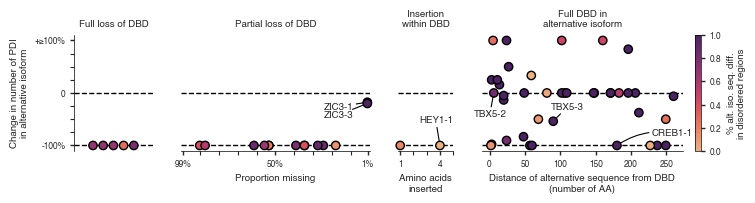

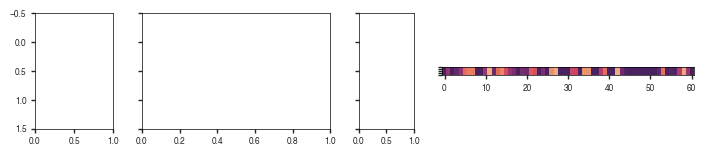

In [35]:
gs_kw = dict(width_ratios=[0.5, 1.2, 0.35, 1.6])
fig, axs = plt.subplots(nrows=1, 
                        ncols=4,
                        sharey=True,
                        gridspec_kw=gs_kw)
fig.set_size_inches(w=8.5, h=1.5)
point_size = 6

axs[0].set_title('Full loss of DBD',
fontsize=fontsize)
sns.swarmplot(data=df,
              y='delta_pdi_trunc', 
              x='dbd_or_flank_affected',
              size=point_size,
              order=[
                     'Full loss\nof DBD',
                     ],
              ax=axs[0],
              palette=palette,
              hue='f_disorder_difference',
               linewidth=1,
               edgecolor="black",
              alpha=1,
             zorder=10)
axs[0].get_legend().remove()

axs[1].set_title('Partial loss of DBD',
fontsize=fontsize)
axs[1].scatter(df.loc[(df['dbd_pct_lost'] > 0) & (df['dbd_pct_lost'] < 100), 'dbd_pct_lost'].values,
               df.loc[(df['dbd_pct_lost'] > 0) & (df['dbd_pct_lost'] < 100), 'delta_pdi_trunc'].values,
           alpha=1,
           s=point_size**2,
            c=df.loc[(df['dbd_pct_lost'] > 0) & (df['dbd_pct_lost'] < 100), 'color'].values,
               linewidth=1,
               edgecolor="black",
           clip_on=False,
              zorder=10)
axs[1].set_xlabel('Proportion missing')
axs[1].set_xlim(100, 0)
axs[1].set_xticks([99, 50, 1])
axs[1].set_xticklabels(['{}%'.format(x)for x in axs[1].get_xticks()])
axs[1].set_xticks(range(10, 91, 10), minor=True)

# annotate zic3
axs[1].annotate("ZIC3-1", xy=(df.loc[(df["alt_iso"] == "ZIC3-1"), 'dbd_pct_lost'].values, 
                              df.loc[(df["alt_iso"] == "ZIC3-1"), 'delta_pdi_trunc'].values),
                xytext=(-10, 0), textcoords='offset points', arrowprops = dict(arrowstyle="-", color="black"),
                ha="right", va="top", fontsize=7,
                bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
axs[1].annotate("ZIC3-3", xy=(df.loc[(df["alt_iso"] == "ZIC3-3"), 'dbd_pct_lost'].values, 
                              df.loc[(df["alt_iso"] == "ZIC3-3"), 'delta_pdi_trunc'].values),
                xytext=(-10, -5), textcoords='offset points', arrowprops = dict(arrowstyle="-", color="black"),
                ha="right", va="top", fontsize=7,
                bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))


axs[2].set_title('Insertion\nwithin DBD',
fontsize=fontsize)
axs[2].scatter(df.loc[(df['dbd_pct_lost'] == 0) & (df['dbd_insertion_n_aa'] > 0), 'dbd_insertion_n_aa'].values,
               df.loc[(df['dbd_pct_lost'] == 0) & (df['dbd_insertion_n_aa'] > 0), 'delta_pdi_trunc'].values,
           alpha=1,
           s=point_size**2,
            c=df.loc[(df['dbd_pct_lost'] == 0) & (df['dbd_insertion_n_aa'] > 0), 'color'].values,
               linewidth=1,
               edgecolor="black",
           clip_on=False,
              zorder=10)
axs[2].set_xlabel('Amino acids\ninserted')
axs[2].set_xticks([1, 4])
axs[2].set_xticks(range(1, 6), minor=True)

# annotate hey1
axs[2].annotate("HEY1-1", xy=(df.loc[(df["alt_iso"] == "HEY1-1"), 'dbd_insertion_n_aa'].values, 
                              df.loc[(df["alt_iso"] == "HEY1-1"), 'delta_pdi_trunc'].values),
                xytext=(-3, 15), textcoords='offset points', arrowprops = dict(arrowstyle="-", color="black"),
                ha="center", va="bottom", fontsize=7,
                bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))

axs[3].set_title('Full DBD in\nalternative isoform', fontsize=fontsize)
axs[3].scatter(df.loc[(df['dbd_affected'] == 'Full DBD in\nalternative isoform') &
                      (df['dbd_insertion_n_aa'] == 0), 'dbd_n_aa_to_change'].values,
               df.loc[(df['dbd_affected'] == 'Full DBD in\nalternative isoform') &
                      (df['dbd_insertion_n_aa'] == 0), 'delta_pdi_trunc'].values,
           alpha=1,
           s=point_size**2,
            c=df.loc[(df['dbd_affected'] == 'Full DBD in\nalternative isoform') &
                     (df['dbd_insertion_n_aa'] == 0), 'color'].values,
               linewidth=1,
               edgecolor="black",
           clip_on=False,
               zorder=10)

axs[3].set_xlabel('Distance of alternative sequence from DBD\n(number of AA)')

# annotate tbx5 and creb1
axs[3].annotate("TBX5-2", xy=(df.loc[(df["alt_iso"] == "TBX5-2"), 'dbd_n_aa_to_change'].values, 
                              df.loc[(df["alt_iso"] == "TBX5-2"), 'delta_pdi_trunc'].values),
                xytext=(9, -12), textcoords='offset points', arrowprops = dict(arrowstyle="-", color="black"),
                ha="right", va="top", fontsize=7,
                bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
axs[3].annotate("TBX5-3", xy=(df.loc[(df["alt_iso"] == "TBX5-3"), 'dbd_n_aa_to_change'].values, 
                              df.loc[(df["alt_iso"] == "TBX5-3"), 'delta_pdi_trunc'].values),
                xytext=(-2, 10), textcoords='offset points', arrowprops = dict(arrowstyle="-", color="black"),
                ha="left", va="center", fontsize=7,
                bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
axs[3].annotate("CREB1-1", xy=(df.loc[(df["alt_iso"] == "CREB1-1"), 'dbd_n_aa_to_change'].values, 
                               df.loc[(df["alt_iso"] == "CREB1-1"), 'delta_pdi_trunc'].values),
                xytext=(25, 9), textcoords='offset points', arrowprops = dict(arrowstyle="-", 
                                                                              connectionstyle="arc3,rad=0.2", 
                                                                              color="black"),
                ha="left", va="center", fontsize=7,
                bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))

# add colorbar
# mirror figure
fig2, axs2 = plt.subplots(nrows=1, 
                        ncols=4,
                        sharey=True,
                        gridspec_kw=gs_kw)
fig2.set_size_inches(w=8.5, h=1.5)
map1 = axs2[3].imshow(np.stack([t, t]), cmap="flare")
fig.colorbar(map1, ax=axs[3], aspect=20, label="% alt. iso. seq. diff.\nin disordered regions")



for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.axhline(y=0, linestyle="dashed", linewidth=1, color="black", zorder=1)
    ax.axhline(y=-1, linestyle="dashed", linewidth=1, color="black", zorder=1)
for ax in axs[1:]:
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_tick_params(which='both', length=0, zorder=1)
for i in [0]:
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].spines['bottom'].set_visible(False)
    axs[i].xaxis.set_tick_params(length=0)
    axs[i].set_xticks([])
axs[0].set_yticks([-1, 0, 1])
axs[0].set_yticks(np.linspace(-1, 1, 9), minor=True)
axs[0].set_yticklabels(['-100%', '0', '+≥100%'])
axs[0].set_ylabel('Change in number of PDI\nin alternative isoform')


fig.savefig('../../figures/fig3/DBD_or_flank_change_vs_PDI_composite_alt_with_distance_colored_annotated.pdf', bbox_inches='tight')

In [36]:
def get_aa_seq(row, col):
    gene = row["gene_symbol"]
    iso = row[col]
    aa_seq = tfs[gene][iso].aa_seq
    return aa_seq

df["ref_iso_aa_seq"] = df.apply(get_aa_seq, col="ref_iso", axis=1)
df["alt_iso_aa_seq"] = df.apply(get_aa_seq, col="alt_iso", axis=1)
df.head()

,gene_symbol,ref_iso,alt_iso,dbd_fraction,dbd_insertion_n_aa,dbd_n_aa_to_change,dbd_flank_affected,dbd_pct_lost,dbd_affected,dbd_or_flank_affected,...,delta_n_aa_disordered,abs_delta_n_aa_disordered,delta_n_aa_ordered,abs_delta_n_aa_ordered,f_disorder_delta_aa,pdi_affected,f_disorder_difference,color,ref_iso_aa_seq,alt_iso_aa_seq
32,CREB1,CREB1-2,CREB1-1,0.000000,0,180,False,0.000000,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,...,-2,2,-12,12,0.142857,True,1.000000,"(0.29408557, 0.13721193, 0.38442775, 1.0)",MTMESGAENQQSGDAAVTEAENQQMTVQAQPQIATLAQVSMPAAHA...,MTMESGAENQQSGDAAVTEAENQQMTVQAQPQIATLAQVSMPAAHA...
67,DLX1,DLX1-1,DLX1-2,1.000000,0,0,True,100.000000,Full loss\nof DBD,Full loss\nof DBD,...,78,78,48,48,0.619048,True,0.680000,"(0.58951566, 0.20622027, 0.44045213, 1.0)",MTMTTMPESLNSPVSGKAVFMEFGPPNQQMSPSPMSHGHYSMHCLH...,MTMTTMPESLNSPVSGKAVFMEFGPPNQQMSPSPMSHGHYSMHCLH...
68,DLX4,DLX4-1,DLX4-2,0.000000,0,24,False,0.000000,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,...,72,72,0,0,1.000000,True,1.000000,"(0.29408557, 0.13721193, 0.38442775, 1.0)",MTSLPCPLPGRDASKAVFPDLAPVPSVAAAYPLGLSPTTAASPNLS...,MKLSVLPPRSLLAPYTVLCCPPDSEKPRLSPELSERRPQAPAKKLR...
69,DLX4,DLX4-1,DLX4-3,0.245614,26,0,True,24.561404,Partial loss\nof DBD,Partial loss\nof DBD,...,113,113,13,13,0.896825,True,0.878378,"(0.40504765, 0.16574261, 0.42072062, 1.0)",MTSLPCPLPGRDASKAVFPDLAPVPSVAAAYPLGLSPTTAASPNLS...,MKLSVLPPRSLLAPYTVLCCPPDSEKPRLSPEPSERRPQAPAKKLR...
70,DLX5,DLX5-1,DLX5-2,1.000000,0,0,True,100.000000,Full loss\nof DBD,Full loss\nof DBD,...,89,89,52,52,0.631206,True,0.695906,"(0.57496549, 0.20230637, 0.44143805, 1.0)",MTGVFDRRVPSIRSGDFQAPFQTSAAMHHPSQESPTLPESSATDSD...,MTGVFDRRVPSIRSGDFQAPFQTSAAMHHPSQESPTLPESSATDSD...


In [37]:
# write df to file for martha
df.to_csv("Fig3A_df.txt", sep="\t", index=False)

In [38]:
n_full_dbd = len(df.loc[(df['dbd_affected'] == 'Full DBD in\nalternative isoform') & 
                        (df['dbd_insertion_n_aa'] == 0)])
n_full_dbd_identical_pdis = len(df.loc[(df['dbd_affected'] == 'Full DBD in\nalternative isoform') & 
                                       (df['dbd_insertion_n_aa'] == 0) &
                                       ((df['delta_pdi_trunc'] == 0))])


print("NUM ISOS WITH FULL DBD (AND NO INSERTIONS WITHIN DBD): %s" % (n_full_dbd))
print("NUM ISOS WITH FULL DBD (AND NO INSERTIONS WITHIN DBD) WITH IDENTICAL PDIS: %s" % (n_full_dbd_identical_pdis))
print("PERCENT ISOS WITH FULL DBD (AND NO INSERTIONS WITHIN DBD) WITH IDENTICAL PDIS: %s" % (n_full_dbd_identical_pdis/
                                                                                         n_full_dbd*100))

NUM ISOS WITH FULL DBD (AND NO INSERTIONS WITHIN DBD): 40
NUM ISOS WITH FULL DBD (AND NO INSERTIONS WITHIN DBD) WITH IDENTICAL PDIS: 13
PERCENT ISOS WITH FULL DBD (AND NO INSERTIONS WITHIN DBD) WITH IDENTICAL PDIS: 32.5


In [39]:
n_full_dbd_gain_pdis = len(df.loc[(df['dbd_affected'] == 'Full DBD in\nalternative isoform') & 
                                       (df['dbd_insertion_n_aa'] == 0) &
                                       ((df['delta_pdi_trunc'] > 0))])

print("NUM ISOS WITH FULL DBD (AND NO INSERTIONS WITHIN DBD) THAT GAIN PDIS: %s" % (n_full_dbd_gain_pdis))
print("PERCENT ISOS WITH FULL DBD (AND NO INSERTIONS WITHIN DBD) THAT GAIN PDIS: %s" % (n_full_dbd_gain_pdis/
                                                                                         n_full_dbd*100))

NUM ISOS WITH FULL DBD (AND NO INSERTIONS WITHIN DBD) THAT GAIN PDIS: 10
PERCENT ISOS WITH FULL DBD (AND NO INSERTIONS WITHIN DBD) THAT GAIN PDIS: 25.0


In [40]:
df.loc[(df['dbd_affected'] == 'Full DBD in\nalternative isoform') & 
                                       (df['dbd_insertion_n_aa'] == 0) &
                                       ((df['delta_pdi_trunc'] > 0))]

,gene_symbol,ref_iso,alt_iso,dbd_fraction,dbd_insertion_n_aa,dbd_n_aa_to_change,dbd_flank_affected,dbd_pct_lost,dbd_affected,dbd_or_flank_affected,...,delta_n_aa_disordered,abs_delta_n_aa_disordered,delta_n_aa_ordered,abs_delta_n_aa_ordered,f_disorder_delta_aa,pdi_affected,f_disorder_difference,color,ref_iso_aa_seq,alt_iso_aa_seq
68,DLX4,DLX4-1,DLX4-2,0.0,0,24,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,...,72,72,0,0,1.000000,True,1.000000,"(0.29408557, 0.13721193, 0.38442775, 1.0)",MTSLPCPLPGRDASKAVFPDLAPVPSVAAAYPLGLSPTTAASPNLS...,MKLSVLPPRSLLAPYTVLCCPPDSEKPRLSPELSERRPQAPAKKLR...
267,MAX,MAX-1,MAX-2,0.0,0,3,True,0.0,Full DBD in\nalternative isoform,DBD flank affected,...,9,9,0,0,1.000000,True,1.000000,"(0.29408557, 0.13721193, 0.38442775, 1.0)",MSDNDDIEVESDEEQPRFQSAADKRAHHNALERKRRDHIKDSFHSL...,MSDNDDIEVESDADKRAHHNALERKRRDHIKDSFHSLRDSVPSLQG...
362,NFIX,NFIX-1,NFIX-2,0.0,0,59,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,...,0,0,8,8,0.000000,True,0.000000,"(0.92907237, 0.68878959, 0.50411509, 1.0)",MYSPYCLTQDEFHPFIEALLPHVRAFSYTWFNLQARKRKYFKKHEK...,MDEFHPFIEALLPHVRAFSYTWFNLQARKRKYFKKHEKRMSKDEER...
438,PKNOX1,PKNOX1-1,PKNOX1-3,0.0,0,160,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,...,59,59,58,58,0.504274,True,0.452991,"(0.80185613, 0.2755178, 0.38925253, 1.0)",MMATQTLSIDSYQDGQQMQVVTELKTEQDPNCSEPDAEGVSPPPVE...,MVKAIQVLRIHLLELEKVNELCKDFCSRYIACLKTKMNSETLLSGE...
439,PKNOX1,PKNOX1-1,PKNOX1-4,0.0,0,102,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,...,58,58,60,60,0.491525,True,0.457627,"(0.79562644, 0.27149928, 0.39203532, 1.0)",MMATQTLSIDSYQDGQQMQVVTELKTEQDPNCSEPDAEGVSPPPVE...,MVKAIQVLRIHLLELEKVNELCKDFCSRYIACLKTKMNSETLLSGE...
469,RARG,RARG-1,RARG-2,0.0,0,27,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,...,10,10,1,1,0.909091,True,1.000000,"(0.29408557, 0.13721193, 0.38442775, 1.0)",MATNKERLFAAGALGPGSGYPGAGFPFAFPGALRGSPPFEMLSPSF...,MYDCMETFAPGPRRLYGAAGPGAGLLRRATGGSCFAGLESFAWPQP...
492,RORC,RORC-3,RORC-4,0.0,0,5,True,0.0,Full DBD in\nalternative isoform,DBD flank affected,...,8,8,13,13,0.380952,True,0.259259,"(0.89554477, 0.43542759, 0.36818855, 1.0)",MDRAPQRQHRASRELLAAKKTHTSQIEVIPCKICGDKSSGIHYGVI...,MRTQIEVIPCKICGDKSSGIHYGVITCEGCKGFFRRSQRCNAAYSC...
493,RXRG,RXRG-1,RXRG-2,0.0,0,14,True,0.0,Full DBD in\nalternative isoform,DBD flank affected,...,128,128,-5,5,0.962406,True,1.000000,"(0.29408557, 0.13721193, 0.38442775, 1.0)",MYGNYSHFMKFPAGYGGSPGHTGSTSMSPSAALSTGKPMDSHPSYT...,MNYPSTSPGSLVKHICAICGDRSSGKHYGVYSCEGCKGFFKRTIRK...
602,TFAP2A,TFAP2A-2,TFAP2A-4,0.0,0,196,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,...,8,8,-2,2,0.800000,True,1.000000,"(0.29408557, 0.13721193, 0.38442775, 1.0)",MLWKLTDNIKYEDCEDRHDGTSNGTARLPQLGTVGQSPYTSAPPLS...,MLVHSFSAMDRHDGTSNGTARLPQLGTVGQSPYTSAPPLSHTPNAD...
637,THRB,THRB-2,THRB-1,0.0,0,11,True,0.0,Full DBD in\nalternative isoform,DBD flank affected,...,-15,15,0,0,1.000000,True,1.000000,"(0.29408557, 0.13721193, 0.38442775, 1.0)",MTPNSMTENGLTAWDKPKHCPDREHDWKLVGMSEACLHRKSHSERR...,MNYCMQEIYEVHPAAGSNCYMQSTDYYAYFEDSPGYSGCDAQAVPS...


## exon diagrams

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


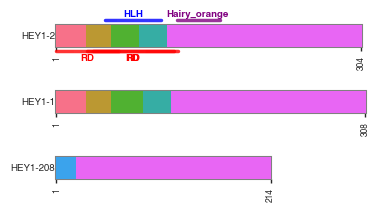

In [41]:
fig, ax = plt.subplots(figsize=(4, 2))

tfs["HEY1"].protein_diagram(only_cloned_isoforms=False, draw_legend=False, ax=ax)
fig.savefig("../../figures/fig3/HEY1_protein_diagram.pdf", bbox_inches="tight", dpi="figure")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


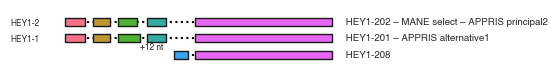

In [42]:
fig, ax = plt.subplots(figsize=(4, 0.75))

tfs["HEY1"].exon_diagram(ax=ax)
fig.savefig("../../figures/fig3/HEY1_exon_diagram.pdf", bbox_inches="tight", dpi="figure")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


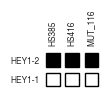

In [43]:
fig, ax = plt.subplots(figsize=(3, 0.5))

y1h_pdi_per_tf_gene_plot("HEY1", ax=ax, data=y1h, iso_order=["HEY1-2", "HEY1-1"])
fig.savefig("../../figures/fig3/HEY1_y1h_plot.pdf", bbox_inches="tight", dpi="figure")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


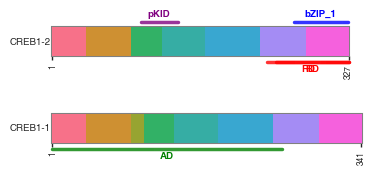

In [44]:
fig, ax = plt.subplots(figsize=(4, 1.5))

tfs["CREB1"].protein_diagram(only_cloned_isoforms=True, draw_legend=False, ax=ax)
fig.savefig("../../figures/fig3/CREB1_protein_diagram.pdf", bbox_inches="tight", dpi="figure")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


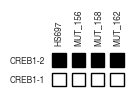

In [45]:
fig, ax = plt.subplots(figsize=(3, 0.5))

y1h_pdi_per_tf_gene_plot("CREB1", ax=ax, data=y1h, iso_order=["CREB1-2", "CREB1-1"])
fig.savefig("../../figures/fig3/CREB1_y1h_plot.pdf", bbox_inches="tight", dpi="figure")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


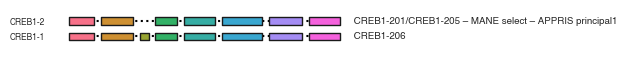

In [46]:
fig, ax = plt.subplots(figsize=(4, 0.5))

tfs["CREB1"].exon_diagram(ax=ax)
fig.savefig("../../figures/fig3/CREB1_exon_diagram.pdf", bbox_inches="tight", dpi="figure")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


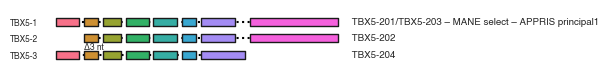

In [47]:
fig, ax = plt.subplots(figsize=(4, 0.75))

tfs["TBX5"].exon_diagram(ax=ax)
fig.savefig("../../figures/fig3/TBX5_exon_diagram.pdf", bbox_inches="tight", dpi="figure")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


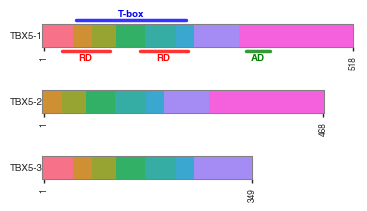

In [48]:
fig, ax = plt.subplots(figsize=(4, 2))

tfs["TBX5"].protein_diagram(only_cloned_isoforms=True, draw_legend=False, ax=ax)
fig.savefig("../../figures/fig3/TBX5_protein_diagram.pdf", bbox_inches="tight", dpi="figure")

In [49]:
baits = [x for x in y1h.columns if x not in ["gene_symbol", "clone_acc"]]

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


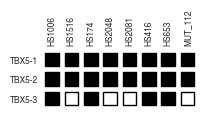

In [50]:
fig, ax = plt.subplots(figsize=(2, 1))


# limit tbx5 data to non-NA
tbx5_y1h = y1h[(y1h["gene_symbol"] == "TBX5")]
na_baits = np.array(baits)[tbx5_y1h[baits].isnull().values.any(axis=0)]
non_na_baits = [x for x in baits if x not in na_baits]
tbx5_y1h = tbx5_y1h[["gene_symbol", "clone_acc"] + non_na_baits]


y1h_pdi_per_tf_gene_plot("TBX5", ax=ax, data=tbx5_y1h)
fig.savefig("../../figures/fig3/TBX5_y1h_plot.pdf", bbox_inches="tight", dpi="figure")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


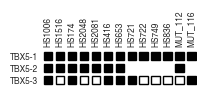

In [51]:
fig, ax = plt.subplots(figsize=(2, 1))


# limit tbx5 data to non-NA
tbx5_y1h = y1h[(y1h["gene_symbol"] == "TBX5")]
na_baits = np.array(baits)[tbx5_y1h[baits].isnull().values.any(axis=0)]
non_na_baits = [x for x in baits if x not in na_baits]
tbx5_y1h = tbx5_y1h[["gene_symbol", "clone_acc"] + non_na_baits]


y1h_pdi_per_tf_gene_plot("TBX5", ax=ax, data=y1h)
fig.savefig("../../figures/fig3/TBX5_y1h_plot.all.pdf", bbox_inches="tight", dpi="figure")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


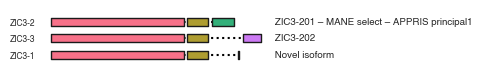

In [52]:
fig, ax = plt.subplots(figsize=(3, 0.75))

tfs["ZIC3"].exon_diagram(ax=ax)
fig.savefig("../../figures/fig3/ZIC3_exon_diagram.pdf", bbox_inches="tight", dpi="figure")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


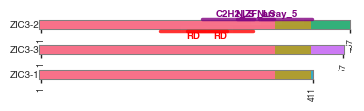

In [53]:
fig, ax = plt.subplots(figsize=(4, 0.75))

tfs["ZIC3"].protein_diagram(only_cloned_isoforms=True, draw_legend=False, ax=ax)
fig.savefig("../../figures/fig3/ZIC3_protein_diagram.pdf", bbox_inches="tight", dpi="figure")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


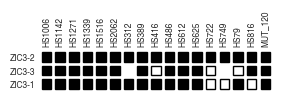

In [54]:
fig, ax = plt.subplots(figsize=(3, 1))

y1h_pdi_per_tf_gene_plot("ZIC3", ax=ax, data=y1h, iso_order=["ZIC3-2", "ZIC3-3", "ZIC3-1"])
fig.savefig("../../figures/fig3/ZIC3_y1h_plot.pdf", bbox_inches="tight", dpi="figure")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


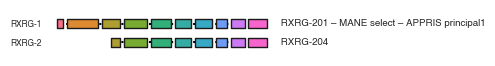

In [55]:
fig, ax = plt.subplots(figsize=(3, 0.6))

tfs["RXRG"].exon_diagram(ax=ax)
fig.savefig("../../figures/fig3/RXRG_exon_diagram.pdf", bbox_inches="tight", dpi="figure")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


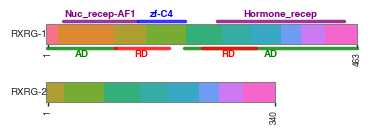

In [56]:
fig, ax = plt.subplots(figsize=(4, 1))

tfs["RXRG"].protein_diagram(only_cloned_isoforms=True, draw_legend=False, ax=ax)
fig.savefig("../../figures/fig3/RXRG_protein_diagram.pdf", bbox_inches="tight", dpi="figure")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


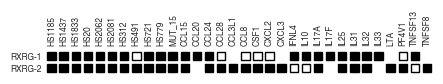

In [57]:
fig, ax = plt.subplots(figsize=(5, 2))

y1h_pdi_per_tf_gene_plot("RXRG", ax=ax, data=y1h)
fig.savefig("../../figures/fig3/RXRG_y1h_plot.pdf", bbox_inches="tight", dpi="figure")

## CREB1 insertion

In [58]:
first_i = tfs["CREB1"].pairwise_changes_relative_to_reference("CREB1-2", "CREB1-1").find("I")
num_i = tfs["CREB1"].pairwise_changes_relative_to_reference("CREB1-2", "CREB1-1").count("I")
last_i = first_i + num_i
last_i

101

In [59]:
creb1_dom = tfs["CREB1"].aa_feature_disruption("CREB1-2")
creb1_dom["ins_rel"] = creb1_dom["start_in_ref_iso"] - last_i
creb1_dom

,gene_symbol,ref_iso,alt_iso,accession,category,start_in_ref_iso,end_in_ref_iso,length,deletion,insertion,frameshift,ins_rel
0,CREB1,CREB1-2,CREB1-1,PF02173,Pfam_domain,98,139,41,0,0,0,-3
1,CREB1,CREB1-2,CREB1-1,PF00170,Pfam_domain,266,326,60,0,0,0,165
2,CREB1,CREB1-2,CREB1-1,PF00170_flank_N,DBD_flank,251,266,15,0,0,0,150
3,CREB1,CREB1-2,CREB1-1,PF00170_flank_C,DBD_flank,326,327,1,0,0,0,225
4,CREB1,CREB1-2,CREB1-1,Tycko_RD_CREB1_HUMAN_bZIP_1_tile-nan,effector_domain,247,327,80,0,0,0,146
5,CREB1,CREB1-2,CREB1-1,DelRosso_RD_CREB1_1,effector_domain,237,327,90,0,0,0,136
